This notebook exists to select the best parameters from the total parameter set calculated from the dataset. Each parameter is tested against the others within a filter method to find any correlations before a wrapper method is used to determine which parameters give the best performance with the classification paradigm.
Want to reduce number of parameters needed to produce a good output so to reduce the chance of overfitting and increase the generalisation of the model.

In [1]:
%run "Parameter_Estimation.ipynb" #allowing access to parameters

Filtering Database


100%|██████████| 549/549 [01:27<00:00,  6.27it/s]


221 remaining out of 290
normalising and preproccessing signals using DWT


100%|██████████| 221/221 [00:00<00:00, 271.79it/s]


6
Calculating Time Domain Features
Calculating Frequency Domain Features
Calculating Non-Linear Domain Features


In [2]:
from scipy.stats import pearsonr #for comparisson of correlations
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_classif #for forward feature selection
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
def get_balanced_accuracy(y_test, y_pred):
    """
    balanced accuracy....
    """
    num_healthy_true = np.sum([x=='Healthy' for x in y_test])
    num_unhealthy_true = len(y_test) - num_healthy_true
    count_healthy_accurate = 0
    count_unhealthy_accurate = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            count_unhealthy_accurate +=1
        elif y_pred[i] == y_test[i] == 'Healthy':
            count_healthy_accurate +=1
    healthy_percentage = count_healthy_accurate/num_healthy_true
    unhealthy_percentage = count_unhealthy_accurate/num_unhealthy_true
    balanced_accuracy = (healthy_percentage + unhealthy_percentage) * 0.5
    return balanced_accuracy

def get_specificity(y_test, y_pred):
    """
    true negative rate
    """
    true_negative = 0
    false_positive = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Healthy':
            true_negative += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
    
    return true_negative / (true_negative+false_positive)
            
def get_f1_score(y_test, y_pred):
    """
    balance between precision and recall
    """
    true_positive = 0
    false_positive = 0
    false_negative = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            true_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Unhealthy':
            false_negative += 1
    return (2*true_positive)/(2*true_positive+false_positive+false_negative)

def scoring_function(model, X, y):
    """
    change to incorporate balanced accuracy 
    """
    
    y_pred = model.predict(X)
    y_test = y
    balanced_acc = get_balanced_accuracy(y_test, y_pred)
    #specificity = get_specificity(y_test, y_pred)
    f1 = get_f1_score(y_test, y_pred)
    
    
    return f1*0.7 + balanced_acc*0.3

def convert_multi_dict_to_array(params, nan_indices):
    no_features = len(params)
    params_list = []
    for j in range(0, no_channels):
        params_array = np.zeros(shape=(len(health_state[nan_indices[j]]), no_features))
        for i, values in enumerate(params.values()):
            params_array[:, i] = values[j]
        params_list.append(params_array)
    return params_list, no_features

def convert_single_dict_to_array(params, nan_indices):
    no_features = len(params)
    params_array = np.zeros((len(health_state[nan_indices]), no_features))
    for i, values in enumerate(params.values()):
        params_array[:, i] = values
    return params_array, no_features

def reduce_parameter_set(params, selected_indices, channel):
    select_params = {}
    for i, key in enumerate(params.keys()):
        if i in selected_indices:
            select_params[key] = params[key][channel]
    return select_params
        
def reduce_parameter_set_single(params, selected_indices):
    select_params = {}
    for i, key in enumerate(params.keys()):
        if i in selected_indices:
            select_params[key] = params[key]
    return select_params
    

First convert the parameters to an array for easy investigation.

In [4]:
#pre-calculation of relevant health array for every channel
nan_indices = []
health_state = allowed_patients.get_diagnoses()
for j in range(0, no_channels):
    signal_nan_indices = []
    for i, signal in enumerate(denoised_signals[:, j]):
        if np.isnan(signal).all():
            signal_nan_indices.append(False)
        else:
            signal_nan_indices.append(True)
    nan_indices.append(signal_nan_indices)
    
health_state = np.array(health_state)
nan_indices = np.array(nan_indices)

In [5]:
params_array, no_features = convert_multi_dict_to_array(params, nan_indices)

desired_no_feats = 4

In [6]:
print(f'Selecting the {desired_no_feats} most important features from {no_features} for each channel')

Selecting the 4 most important features from 18 for each channel


To select the most important features to be used in analysis used forward sfs

In [7]:
def forward_selection(params, health_state, scorer=scoring_function, k=6):
    
    X_train, X_test, y_train, y_test = train_test_split(params, health_state, test_size=0.3, stratify = health_state)

    #initialise svc
    svm = SVC(class_weight='balanced')

    SFS_forward = SequentialFeatureSelector(estimator=svm, scoring=scoring_function, cv=3, n_features_to_select=k)

    SFS_forward.fit(X_train, y_train)

    selected_indices = SFS_forward.get_support(indices=True)
    
    return selected_indices

Filter methods

In [8]:
def filter_method(params, health_state, k=6, scorer=mutual_info_classif):
    # Apply SelectKBest with mutual information
    selector = SelectKBest(score_func=scorer, k=k)
    
    
    X_new = selector.fit_transform(params, health_state)
    
    # Get the indices of selected features
    selected_indices = selector.get_support(indices=True)
    
    return selected_indices

Combining approaches

In [9]:
def run_feature_selection():
    selected_params = {}
    for i in range(0, no_channels):
        #find indices to keep through filter method

        chosen_indices_filt = filter_method(params_array[i], health_state[nan_indices[i]], k=8)#encoded health state?

        #reduce the parameter based on these indices
        reduced_params = reduce_parameter_set(params, chosen_indices_filt, i)

        #convert new params dict back into array
        reduced_params_array, no_features = convert_single_dict_to_array(reduced_params, nan_indices[i])

        #find 4 best features through sfs
        chosen_indices_filt_sfs = forward_selection(reduced_params_array, health_state[nan_indices[i]], scorer=scoring_function, k=desired_no_feats)

        selected_params[i] = reduce_parameter_set_single(reduced_params, chosen_indices_filt_sfs)
    return selected_params

In [10]:
selected_params = run_feature_selection()
for i in range(0, no_channels):
    print(f"Selected features for channel {i}:")
    print(list(selected_params[i].keys()))

Selected features for channel 0:
['RR amps', 'RMSSD', 'sd2', 'age']
Selected features for channel 1:
['RR std', 'RR amps', 'sd2', 'age']
Selected features for channel 2:
['RR std', 'sd1', 'sd2', 'age']
Selected features for channel 3:
['RR std', 'RR amps', 'std', 'age']
Selected features for channel 4:
['skews', 'lf', 'shannon en', 'age']
Selected features for channel 5:
['mean', 'lf', 'sd2', 'age']


In [11]:
from collections import defaultdict, Counter

# initialize dict to count feature selections for each channel
feature_counts = defaultdict(Counter)

# select features 100 times and update the counts
for _ in tqdm(range(100)):
    selected_features = run_feature_selection()
    for i in range(0, 6):
        feature_counts[i].update(selected_features[i].keys())
                                 

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


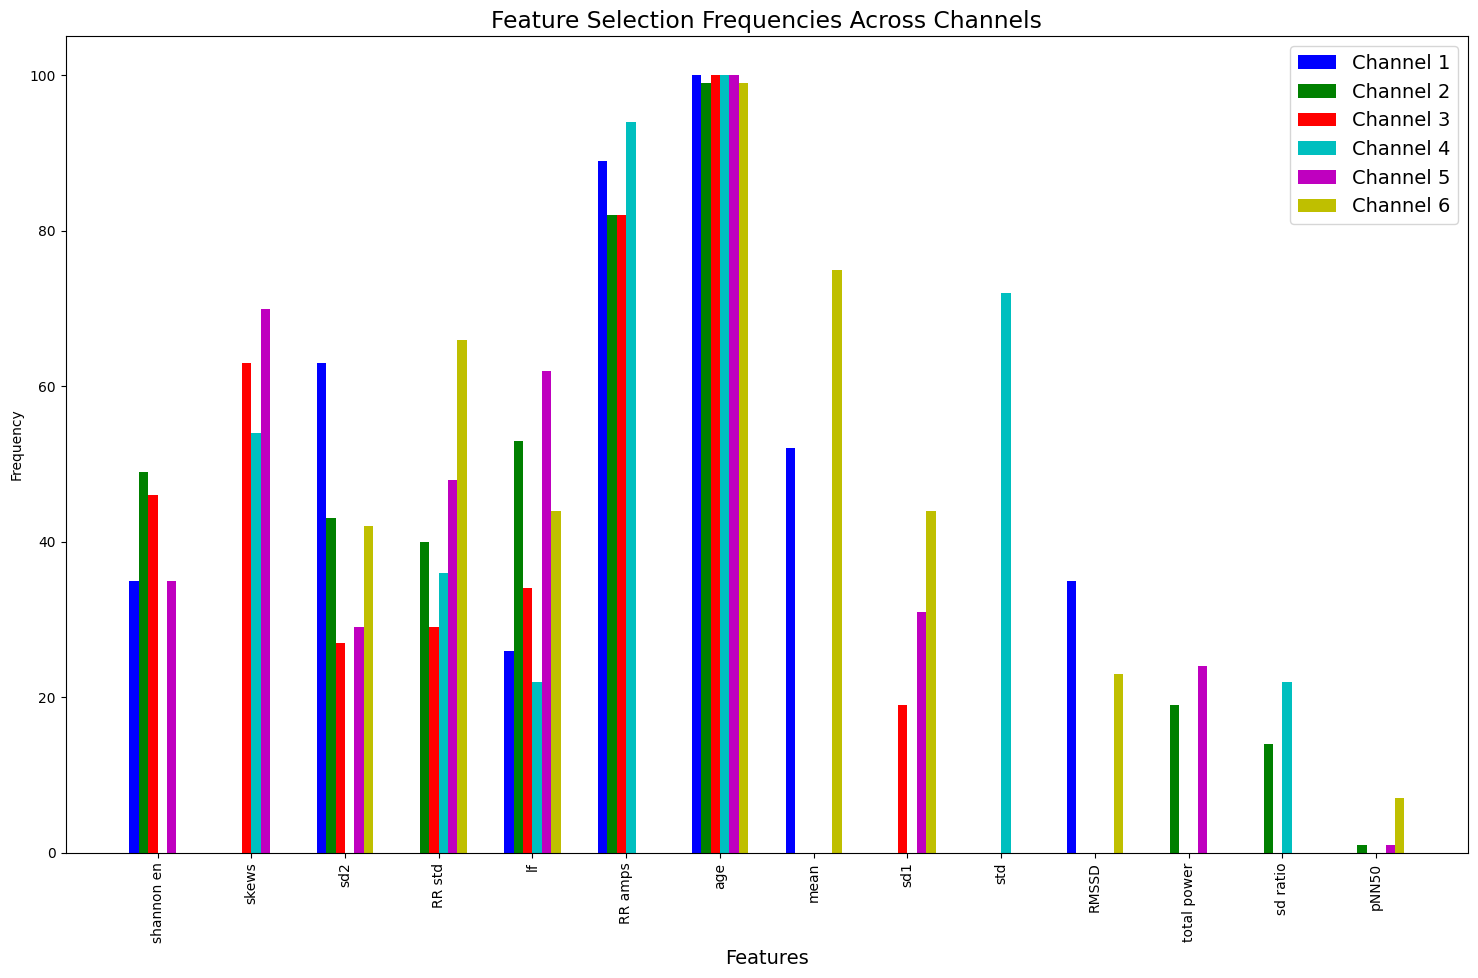

In [12]:

# Combine all features from all channels and calculate their total frequencies
total_feature_counts = Counter()
for features in feature_counts.values():
    total_feature_counts.update(features)

# sort features by total frequency
sorted_features = [feature for feature, count in total_feature_counts.most_common()]


middle_index = len(sorted_features) // 2
sorted_features = sorted_features[:middle_index][::-1] + sorted_features[middle_index:]

# bar chart of frequencies
fig, ax = plt.subplots(figsize=(15, 10))

plt.rcParams.update({'font.size': 14})

bar_width = 0.1  
indices = list(range(len(sorted_features)))

# colors for each channel
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for channel in range(6):
    counts = [feature_counts[channel][feature] for feature in sorted_features]
    bar_positions = [i + channel * bar_width for i in indices]
    ax.bar(bar_positions, counts, bar_width, label=f'Channel {channel+1}', color=colors[channel])


ax.set_xticks([i + bar_width * 2.5 for i in indices])
ax.set_xticklabels(sorted_features, rotation=90)


ax.set_xlabel('Features', fontsize = 14)
ax.set_ylabel('Frequency')
ax.set_title('Feature Selection Frequencies Across Channels')
ax.legend()

plt.tight_layout()
plt.savefig('feature_selection_frequencies_combined.png', bbox_inches='tight')
plt.show()